In [21]:
# Imports
import os
import copy
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tools.preprocessing import process_df, create_dataset
from models.dcn import DCN, DCNParallel

In [2]:
ratings_df = pd.read_csv('datasets/ml-latest-small/ratings.csv', encoding='latin-1')
movies_df = pd.read_csv('datasets/ml-imdb.csv',encoding='latin-1', sep="\t")

In [3]:
# Rename for consistency
movies_df.rename(columns={'movie_year': 'year'}, inplace=True)
movies_df.rename(columns={'directors': 'director'}, inplace=True)
movies_df.drop('imdbId', axis=1, inplace=True)
movies_df.drop('title', axis=1, inplace=True)
merged_df = pd.merge(ratings_df, movies_df, on='movieId', how='left')

In [4]:
df = process_df(merged_df)

In [5]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_parts = np.array_split(df_shuffled, 5)

datasets = []

for i in range(5):
    datasets.append(create_dataset(df_parts[i]))

C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# 80:20 Training:Test

In [17]:
dataset = create_dataset(df)

tf.random.set_seed(42)
shuffled = dataset.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(70_000)
valid = shuffled.skip(70_000).take(15_000)
test = shuffled.skip(85_000).take(15_000)

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_valid = valid.batch(4096).cache()
cached_test = test.batch(4096).cache()

In [19]:
def run_models(deep_layer_sizes, projection_dim=None, num_runs=5, epochs=20, lr=0.001):
    models = []
    rmses = []
    histories = []

    for i in range(num_runs):
        model = DCN(df, deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        model.adapt()
        
        model.compile(optimizer=tf.keras.optimizers.Adam(lr))
        models.append(model)
    
        history = model.fit(cached_train, epochs=epochs, validation_data=cached_valid, verbose=False)
        histories.append(history)
        
        metrics = model.evaluate(cached_test, return_dict=True)
        rmses.append(metrics["RMSE"])
        predictions = model.predict(cached_test)

    mean, stdv = np.average(rmses), np.std(rmses)

    return {"model": models, "rmses": rmses, "history": histories}

In [28]:
epochs = 20
lr = 0.001

results = run_models(deep_layer_sizes=[192, 192], num_runs=1, epochs=epochs, lr=lr)

C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - RMSE: 0.8640 - loss: 0.7437 - regularization_loss: 0.0000e+00 - total_loss: 0.7437
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


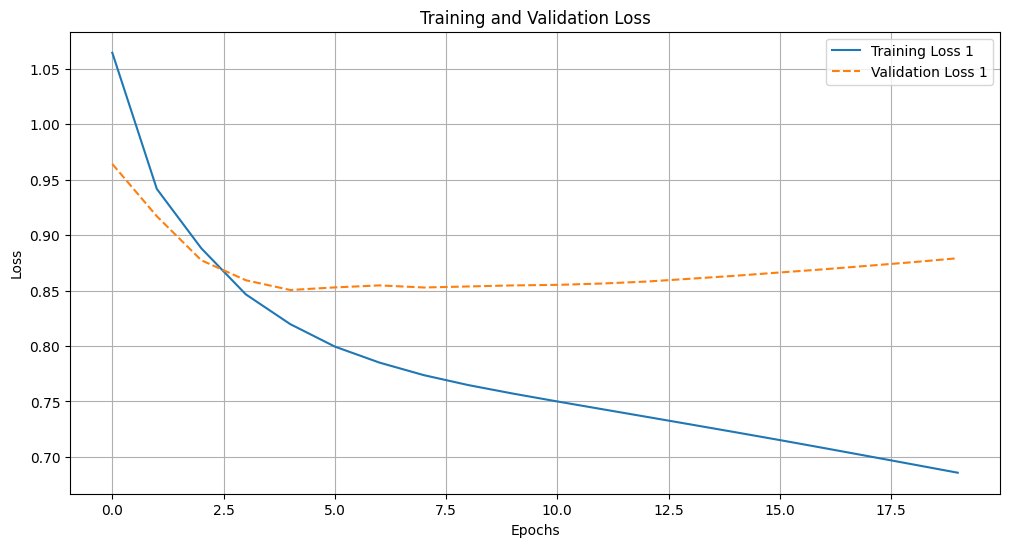

In [29]:
plt.figure(figsize=(12, 6))
    
for i, history in enumerate(results["history"]):
    plt.plot(history.history['RMSE'], label=f'Training Loss {i+1}')
    plt.plot(history.history['val_RMSE'], label=f'Validation Loss {i+1}', linestyle='--')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Cross Validation:

In [14]:
def split_dataset(datasets, i):
    # Create the validation set
    val_dataset = datasets[i].batch(4096).cache()

    if i != 4: # 0,1,2,3
        train_datasets = datasets[i+1]
    else:
        train_datasets = datasets[0]
    
    # Create the training set by combining the other folds
    for j in range(5):
        if j != i:
            train_datasets = train_datasets.concatenate(datasets[j])
    return val_dataset, train_datasets.shuffle(100_000).batch(8192).cache()

def cross_validate(deep_layer_sizes, projection_dim=None, lr=0.001, epochs=20, parallel=False):
    rmses = []
    models = []
    histories = []
    for i in range(5):
        print(f"Fold {i + 1}")

        val_dataset, train_datasets = split_dataset(datasets, i)

        if parallel == True:
            model = DCNParallel(df, deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        else:
            model = DCN(df, deep_layer_sizes=deep_layer_sizes,
                        projection_dim=projection_dim)
        model.adapt()
        
        model.compile(optimizer=tf.keras.optimizers.Adam(lr))
        models.append(model)
    
        history = model.fit(train_datasets, epochs=epochs, validation_data=val_dataset, verbose=False)
        histories.append(history)
        metrics = model.evaluate(val_dataset, return_dict=True)
        rmses.append(metrics["RMSE"])
        # epochs_trained = len(history.history['loss'])
        # print(f"Training stopped at epoch {epochs_trained}")

    return {"model": models, "rmses": rmses, "histories": history}

In [12]:
history = cross_validate(deep_layer_sizes=[192, 192], epochs=20)

Fold 1


C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RMSE: 0.8676 - loss: 0.7483 - regularization_loss: 0.0000e+00 - total_loss: 0.7483
Fold 2


C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - RMSE: 0.8543 - loss: 0.7300 - regularization_loss: 0.0000e+00 - total_loss: 0.7300
Fold 3


C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - RMSE: 0.8520 - loss: 0.7233 - regularization_loss: 0.0000e+00 - total_loss: 0.7233
Fold 4


C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RMSE: 0.8500 - loss: 0.7266 - regularization_loss: 0.0000e+00 - total_loss: 0.7266
Fold 5


C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - RMSE: 0.8534 - loss: 0.7394 - regularization_loss: 0.0000e+00 - total_loss: 0.7394


In [15]:
cross_validate(deep_layer_sizes=[192, 192], epochs=20, parallel=True)

Fold 1


C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_parallel', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - RMSE: 0.8718 - loss: 0.7531 - regularization_loss: 0.0000e+00 - total_loss: 0.7531
Fold 2


C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_parallel_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - RMSE: 0.8571 - loss: 0.7333 - regularization_loss: 0.0000e+00 - total_loss: 0.7333
Fold 3


C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_parallel_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - RMSE: 0.8582 - loss: 0.7356 - regularization_loss: 0.0000e+00 - total_loss: 0.7356 
Fold 4


C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_parallel_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - RMSE: 0.8514 - loss: 0.7284 - regularization_loss: 0.0000e+00 - total_loss: 0.7284 
Fold 5


C:\Users\aliso\icl\Movie-RS\venv\lib\site-packages\keras\src\layers\layer.py:361: UserWarning: `build()` was called on layer 'dcn_parallel_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - RMSE: 0.8563 - loss: 0.7418 - regularization_loss: 0.0000e+00 - total_loss: 0.7418


{'model': [<DCNParallel name=dcn_parallel, built=True>,
  <DCNParallel name=dcn_parallel_1, built=True>,
  <DCNParallel name=dcn_parallel_2, built=True>,
  <DCNParallel name=dcn_parallel_3, built=True>,
  <DCNParallel name=dcn_parallel_4, built=True>],
 'rmses': [0.8681913614273071,
  0.8562690615653992,
  0.8575937747955322,
  0.8508028984069824,
  0.8611401915550232],
 'histories': <keras.src.callbacks.history.History at 0x1cef0ef4d00>}